# Github comments sentiment analysis

- Option 1: Use [Detoxify model](https://github.com/unitaryai/detoxify)
- Option 2: Use LLM (Claude 3.5 Haiku) to assess toxicity
- Option 3: Use multi-step LLM assessment, i.e. first toxicity assessment, then sequentially review the toxicity and validate accross batch? 

In [3]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from dotenv import load_dotenv
from tinydb import Query, TinyDB
from tqdm import tqdm

from openowl.clients import OpenOwlClient
from openowl.gh_llm import get_issue_summarization
from openowl.gh_sentiment_analysis import get_toxicity_scores_detoxify, filter_issues_by_dependency, update_toxicity_scores_llm, create_toxicity_dataframe

from openowl.logger_config import setup_logger
from openowl.utils import extract_github_info, sort_version_list

logger = setup_logger(__name__)
load_dotenv()

True

In [4]:
PROJECT_ROOT = Path().absolute().parent

In [6]:
# Define package info
package_manager="pypi"
github_url="https://github.com/pydantic/pydantic"
package_version=None
debug=True

# extract package info from github url
package_owner, package_name = extract_github_info(github_url)

# if no version is provided, get latest version
if package_version is None:
    oowl_client = OpenOwlClient()
    package_versions = oowl_client.get_package_versions(
        package_manager, package_name
    )
    package_versions = sort_version_list(package_versions)
    package_version = package_versions[0]
    logger.info(f"No version provided, took the latest version: {package_version}")

dependency = {
    "package_manager": package_manager,
    "owner": package_owner,
    "name": package_name,
    "version": package_version,
}

# Initialize/load TinyDB
if PROJECT_ROOT:
    db = TinyDB(Path(PROJECT_ROOT / os.environ.get("PATH_DB")))
else:
    db = TinyDB(Path(os.environ.get("PATH_DB")))
dependencies_table = db.table("dependencies")
issues_table = db.table("issues")
issue_dependency_table = db.table("issue_dependency")

2024-12-22 22:09:32,643 - __main__ - INFO - No version provided, took the latest version: 2.10.4


## Option 1: Use Detoxify model

- We use the [Detoxify model "original"](https://github.com/unitaryai/detoxify) to assess the toxicity of the comments.

In [7]:
# get toxicity scores, add them to the issues table and obtain dataframe
comments_df = get_toxicity_scores_detoxify(issues_table)

Analyzing comment toxicity: 100%|██████████| 78/78 [00:05<00:00, 15.43it/s]


In [8]:
print(f"Number of comments: {len(comments_df)}")

comments_df['datetime'] = pd.to_datetime(comments_df['datetime'])
print(f"Time range: {comments_df['datetime'].min().strftime(
    '%Y-%m-%d %H:%M')} to {comments_df['datetime'].max().strftime('%Y-%m-%d %H:%M')}")

Number of comments: 78
Time range: 2024-12-01 13:05 to 2024-12-08 05:58


In [9]:
comments_df.head()

,datetime,issue_id,comment_details,author_association,user,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
43,2024-12-01 13:05:40+00:00,2709132946,## [CodSpeed Performance Report](https://codsp...,NONE,codspeed-hq[bot],0.000805,0.000107,0.000187,0.000113,0.000178,0.000136
44,2024-12-01 13:08:37+00:00,2709132946,"## Coverage report\n\n\n<img title=""Coverage f...",CONTRIBUTOR,github-actions[bot],0.001093,0.000105,0.000222,0.000114,0.000185,0.000137
45,2024-12-01 14:47:25+00:00,2709132946,please review (and thank you ❤️ ),NONE,thejcannon,0.000547,0.000132,0.000187,0.000135,0.000175,0.000142
46,2024-12-01 19:04:06+00:00,2709128734,Thanks for the report. While we can accept the...,MEMBER,Viicos,0.000696,0.000118,0.000199,0.000115,0.000172,0.000138
47,2024-12-01 19:14:37+00:00,2709128734,> We first generate the JSON Schema for the in...,NONE,thejcannon,0.000739,0.000115,0.000189,0.000120,0.000176,0.000139


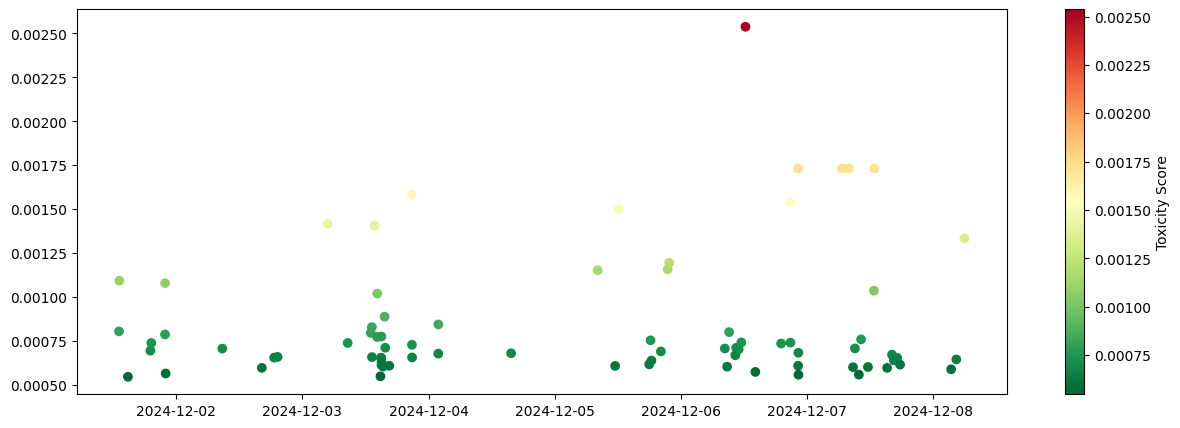

In [13]:
# plot toxicity over time

plt.figure(figsize=(15,5))
plt.scatter(comments_df["datetime"], comments_df["toxicity"], 
           c=comments_df["toxicity"], cmap='RdYlGn_r', 
           marker='o')
plt.colorbar(label='Toxicity Score')

hmm. the above graph and assessment doesn't really look right. Way too noisy and it's unclear what the threshold for toxic commetents should be. 

---

## Option 2: Use LLM based toxicity assessment

In [16]:
comments_df_llm = get_toxicity_scores_llm(issues_table, "claude-3-5-haiku-latest")


Analyzing comment toxicity: 100%|██████████| 78/78 [04:08<00:00,  3.19s/it]


In [17]:

comments_df_llm


,datetime,issue_id,comment_details,author_association,user,reactions_plus1,reactions_minus1,reactions_laugh,reactions_hooray,reactions_confused,reactions_heart,reactions_rocket,reactions_eyes,toxicity_llm_score,toxicity_llm_rationale
43,2024-12-01T13:05:40Z,2709132946,## [CodSpeed Performance Report](https://codsp...,NONE,codspeed-hq[bot],0,0,0,0,0,0,0,0,1,"This is a completely neutral, professional per..."
44,2024-12-01T13:08:37Z,2709132946,"## Coverage report\n\n\n<img title=""Coverage f...",CONTRIBUTOR,github-actions[bot],0,0,0,0,0,0,0,0,1,This is an automated coverage report comment c...
45,2024-12-01T14:47:25Z,2709132946,please review (and thank you ❤️ ),NONE,thejcannon,1,0,0,0,0,0,0,0,1,"The comment is polite, respectful, and include..."
46,2024-12-01T19:04:06Z,2709128734,Thanks for the report. While we can accept the...,MEMBER,Viicos,0,0,0,0,0,0,0,0,1,"This is a highly technical, professional, and ..."
47,2024-12-01T19:14:37Z,2709128734,> We first generate the JSON Schema for the in...,NONE,thejcannon,0,0,0,0,0,0,0,0,1,"The comment is a thoughtful, technical discuss..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2024-12-07T17:10:35Z,2722132901,But isn't it good if the columns are updated b...,NONE,kevkle,0,0,0,0,0,0,0,0,1,"The comment appears to be a neutral, construct..."
71,2024-12-07T17:43:53Z,2722132901,Or that it should be fixed with another parame...,NONE,kevkle,0,0,0,0,0,0,0,0,2,"The comment appears to be a neutral, technical..."
72,2024-12-08T03:26:32Z,2722132901,"Seems `join` is more suitable in this case, or...",CONTRIBUTOR,yuanx749,0,0,0,0,0,0,0,0,1,The comment is a constructive suggestion offer...
0,2024-12-08T04:25:51Z,2724919914,/preview,CONTRIBUTOR,yuanx749,0,0,0,0,0,0,0,0,1,"The comment ""/preview"" appears to be a neutral..."


In [18]:
comments_df_llm["toxicity_llm_score"] = comments_df_llm["toxicity_llm_score"].astype(float)

Plot with toxicity score

In [43]:
def wrap_text(text, width=50):
    """Wrap text to specified width by inserting <br> tags.
    
    Args:
        text (str): Text to wrap
        width (int): Maximum width of each line
    
    Returns:
        str: Text with <br> tags inserted for line breaks
    """
    words = text.split()
    lines = []
    current_line = []
    current_length = 0
    
    for word in words:
        if current_length + len(word) + 1 <= width:
            current_line.append(word)
            current_length += len(word) + 1
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
    
    if current_line:
        lines.append(' '.join(current_line))
    
    return '<br>'.join(lines)

def create_toxicity_scatter_plot(df, comment_column='comment_details', score_column='toxicity_llm_score'):
    """Create an interactive scatter plot of toxicity scores.
    
    Args:
        df (pd.DataFrame): DataFrame containing the toxicity data
        comment_column (str): Name of column containing comment text
        score_column (str): Name of column containing toxicity scores
    
    Returns:
        go.Figure: Plotly figure object
    """
    wrapped_comments = [wrap_text(str(text)) for text in df[comment_column]]
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df['datetime'],
            y=df[score_column],
            mode='markers',
            marker=dict(
                size=10,
                color=df[score_column],
                colorscale=[[0, 'green'], [1, 'red']],
                colorbar=dict(title='Toxicity Score'),
                cmin=1,
                cmax=5
            ),
            hovertemplate="""
            <b>Time</b>: %{x}<br>
            <b>Toxicity Score</b>: %{y}<br>
            <b>Comment</b>: %{customdata}
            <extra></extra>
            """,
            customdata=wrapped_comments
        )
    )
    
    fig.update_layout(
        title='Raw Toxicity Scores',
        xaxis_title='Time',
        yaxis_title='Toxicity Score',
        height=300,
        width=1500,
        showlegend=False,
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            align='left'
        )
    )
    
    return fig


Plot, alternative to the plot above, including negative reactions

In [41]:
def wrap_text(text, width=50):
    """Wrap text to specified width by inserting <br> tags.
    
    Args:
        text (str): Text to wrap
        width (int): Maximum width of each line
    
    Returns:
        str: Text with <br> tags inserted for line breaks
    """
    words = text.split()
    lines = []
    current_line = []
    current_length = 0
    
    for word in words:
        if current_length + len(word) + 1 <= width:
            current_line.append(word)
            current_length += len(word) + 1
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
    
    if current_line:
        lines.append(' '.join(current_line))
    
    return '<br>'.join(lines)

def create_toxicity_scatter_plot(df, comment_column='comment_details', score_column='toxicity_llm_score'):
    """Create an interactive scatter plot of toxicity scores.
    
    Args:
        df (pd.DataFrame): DataFrame containing the toxicity data
        comment_column (str): Name of column containing comment text
        score_column (str): Name of column containing toxicity scores
    
    Returns:
        go.Figure: Plotly figure object
    """
    wrapped_comments = [wrap_text(str(text)) for text in df[comment_column]]
    
    fig = go.Figure()
    
    # Add toxicity score scatter points
    fig.add_trace(
        go.Scatter(
            x=df['datetime'],
            y=df[score_column],
            mode='markers',
            marker=dict(
                size=10,
                color=df[score_column],
                colorscale=[[0, 'green'], [1, 'red']],
                colorbar=dict(title='Toxicity Score'),
                cmin=1,
                cmax=5
            ),
            name='Toxicity Score',
            hovertemplate="""
            <b>Time</b>: %{x}<br>
            <b>Toxicity Score</b>: %{y}<br>
            <b>Comment</b>: %{customdata}
            <extra></extra>
            """,
            customdata=wrapped_comments
        )
    )
    
    # Add negative reactions as black squares (only for non-zero values)
    df_negative = df[df['reactions_minus1'] > 0]
    if not df_negative.empty:
        fig.add_trace(
            go.Scatter(
                x=df_negative['datetime'],
                y=df_negative['reactions_minus1'],
                mode='markers',
                marker=dict(
                    size=10,
                    symbol='square',
                    color='black'
                ),
                name='Negative Reactions',
                hovertemplate="""
                <b>Time</b>: %{x}<br>
                <b>Negative Reactions</b>: %{y}
                <extra></extra>
                """
            )
        )
    
    fig.update_layout(
        title='Raw Toxicity Scores and Negative Reactions',
        xaxis_title='Time',
        yaxis_title='Score / Count',
        height=300,
        width=1500,
        showlegend=True,
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            align='left'
        )
    )
    
    return fig


In [36]:
df = create_toxicity_dataframe(db, dependency)


2024-12-22 22:36:40,565 - openowl.gh_sentiment_analysis - INFO - Found 400 issues for pydantic/pydantic v2.10.4


In [37]:
df.head()

,datetime,issue_id,issue_url,comment_details,author_association,user,reactions_plus1,reactions_minus1,reactions_laugh,reactions_hooray,reactions_confused,reactions_heart,reactions_rocket,reactions_eyes,toxicity_llm_score,toxicity_llm_rationale
1796,2023-07-28 13:22:06+00:00,1826197286,https://github.com/pydantic/pydantic/issues/6928,Since it's always nice when similar libraries ...,NONE,jcrist,1,0,0,0,0,0,0,0,NaN,None
1797,2023-07-28 13:23:34+00:00,1826197286,https://github.com/pydantic/pydantic/issues/6928,Thank you Jim! We'll take a look. Indeed it wo...,MEMBER,adriangb,0,0,0,0,0,0,0,0,NaN,None
1789,2023-08-01 09:19:23+00:00,1829371655,https://github.com/pydantic/pydantic/issues/6961,Thanks @jharrisonSV . I think we need to impro...,MEMBER,Kludex,0,0,0,0,0,0,0,0,NaN,None
1762,2023-08-02 14:56:34+00:00,1833253507,https://github.com/pydantic/pydantic/issues/6994,"I could replace the type alias `B = list[A[T,...",CONTRIBUTOR,haoyun,0,0,0,0,0,0,0,0,NaN,None
1790,2023-08-02 16:20:54+00:00,1829371655,https://github.com/pydantic/pydantic/issues/6961,I think it's more than just the migration guid...,NONE,jharrisonSV,0,0,0,0,0,0,0,0,NaN,None


In [38]:
# Filter for rows where toxicity_llm_score is not null/NaN
filtered_df = df[df['toxicity_llm_score'].notna()]
filtered_df.head()

,datetime,issue_id,issue_url,comment_details,author_association,user,reactions_plus1,reactions_minus1,reactions_laugh,reactions_hooray,reactions_confused,reactions_heart,reactions_rocket,reactions_eyes,toxicity_llm_score,toxicity_llm_rationale
203,2024-11-04 12:52:48+00:00,2629221439,https://github.com/pydantic/pydantic/issues/10753,"@dhorkel,\r\n\r\nThanks for the report. Indeed...",MEMBER,sydney-runkle,1,0,0,0,0,0,0,0,1.0,"The comment is professional, constructive, and..."
223,2024-11-04 17:27:59+00:00,2616759015,https://github.com/pydantic/pydantic/issues/10726,"Hey @ClaytonAndTheClayTones,\r\n\r\nFeel free,...",MEMBER,sydney-runkle,0,0,0,0,0,0,0,0,1.0,"The comment is a professional, constructive te..."
224,2024-11-04 17:34:46+00:00,2616759015,https://github.com/pydantic/pydantic/issues/10726,@sydney-runkle @andrey-berenda \r\n\r\nI agree...,NONE,ClaytonAndTheClayTones,0,0,0,0,0,1,0,0,2.0,The comment is technically critical but profes...
225,2024-11-04 17:44:36+00:00,2616759015,https://github.com/pydantic/pydantic/issues/10726,From my point of view it is not backward compa...,NONE,andrey-berenda,1,0,0,0,0,0,0,0,2.0,"The comment is professional and constructive, ..."
226,2024-11-04 18:03:51+00:00,2616759015,https://github.com/pydantic/pydantic/issues/10726,> From my point of view it is not backward com...,NONE,ClaytonAndTheClayTones,1,0,0,0,0,0,0,0,1.0,"The comment is entirely constructive, respectf..."


In [44]:
# Create and display the plot

fig = create_toxicity_scatter_plot(filtered_df)
fig.show()


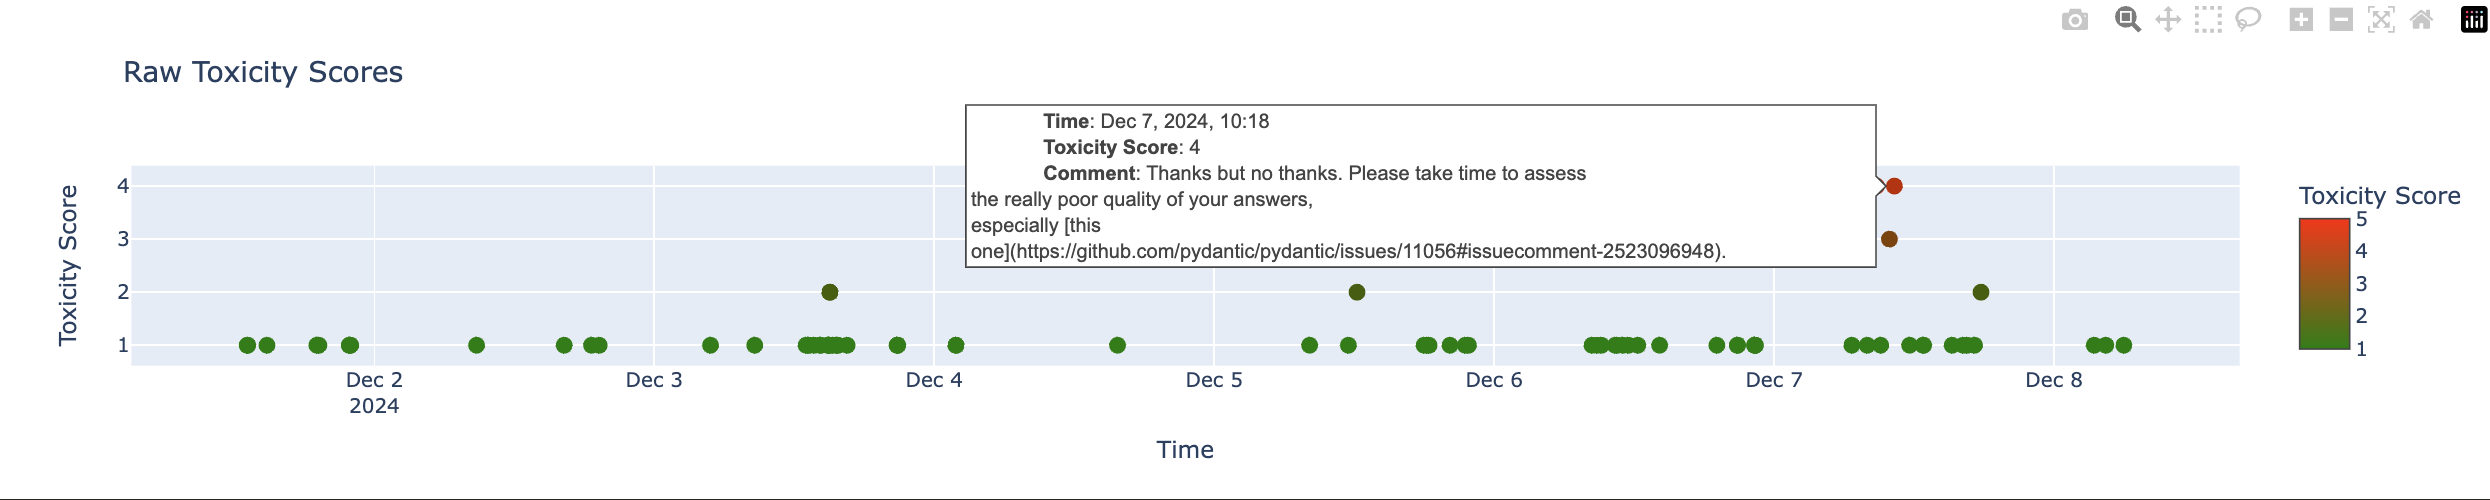

This looks much better. In this sample, there are indeed a few toxic ones. 


In [45]:
def create_reaction_plot(df, reaction_col, title, y_axis_label):
    """Create a line plot for GitHub reactions over time.
    
    Args:
        df: DataFrame containing the reaction data
        reaction_col: Column name for the reaction counts
        title: Plot title
        y_axis_label: Label for y-axis
        
    Returns:
        plotly.graph_objects.Figure
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['datetime'],
        y=df[reaction_col],
        mode='lines+markers',
        marker=dict(color='black'),
        line=dict(color='black'),
        hovertemplate='<b>Date</b>: %{x}<br>' +
                      '<b>' + y_axis_label + '</b>: %{y}<br>' +
                      '<b>Comment</b>: %{text}<br><extra></extra>',
        text=df['comment_details']
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title=y_axis_label,
        height=300,
        width=1500,
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white',
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            align='left'
        )
    )
    return fig


In [30]:

# Filter for rows with confused or minus1 reactions
filtered_df = df[(df['reactions_confused'] > 0) | (df['reactions_minus1'] > 0)]

# Create and display plots
fig_confused = create_reaction_plot(
    filtered_df,
    'reactions_confused',
    'Confused Reactions Over Time',
    'Number of Confused Reactions'
)

fig_minus1 = create_reaction_plot(
    filtered_df, 
    'reactions_minus1',
    'Negative (-1) Reactions Over Time',
    'Number of Negative Reactions'
)

fig_confused.show()
fig_minus1.show()


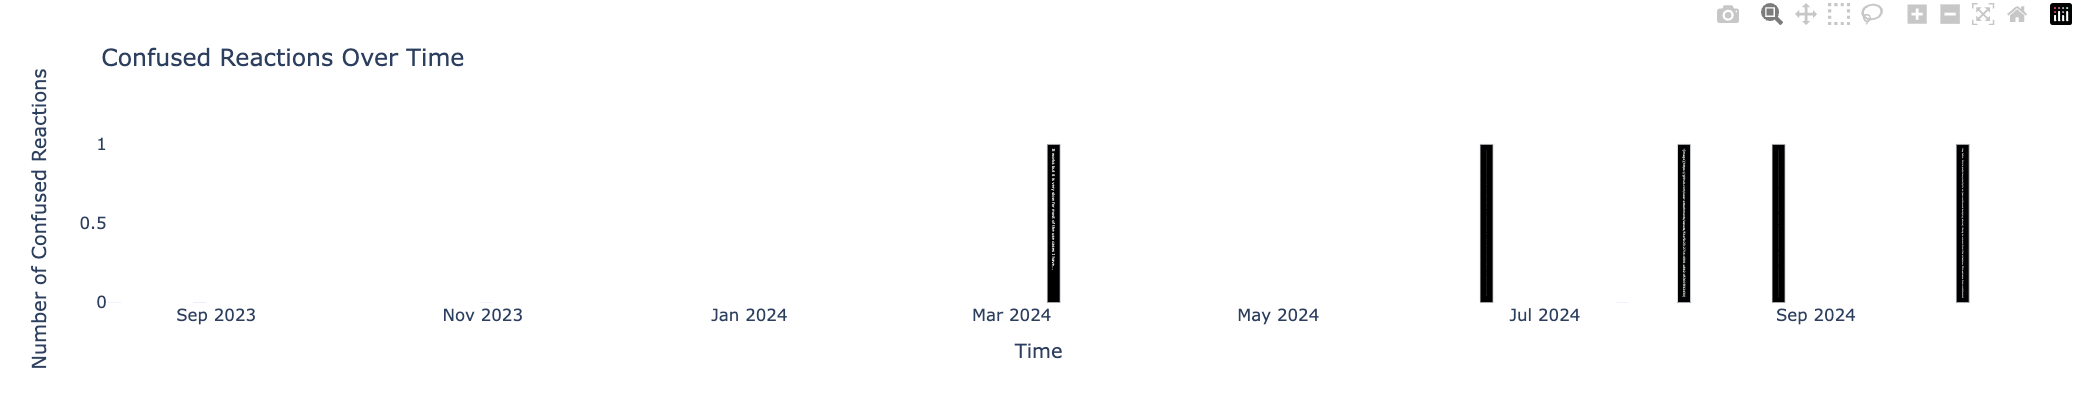
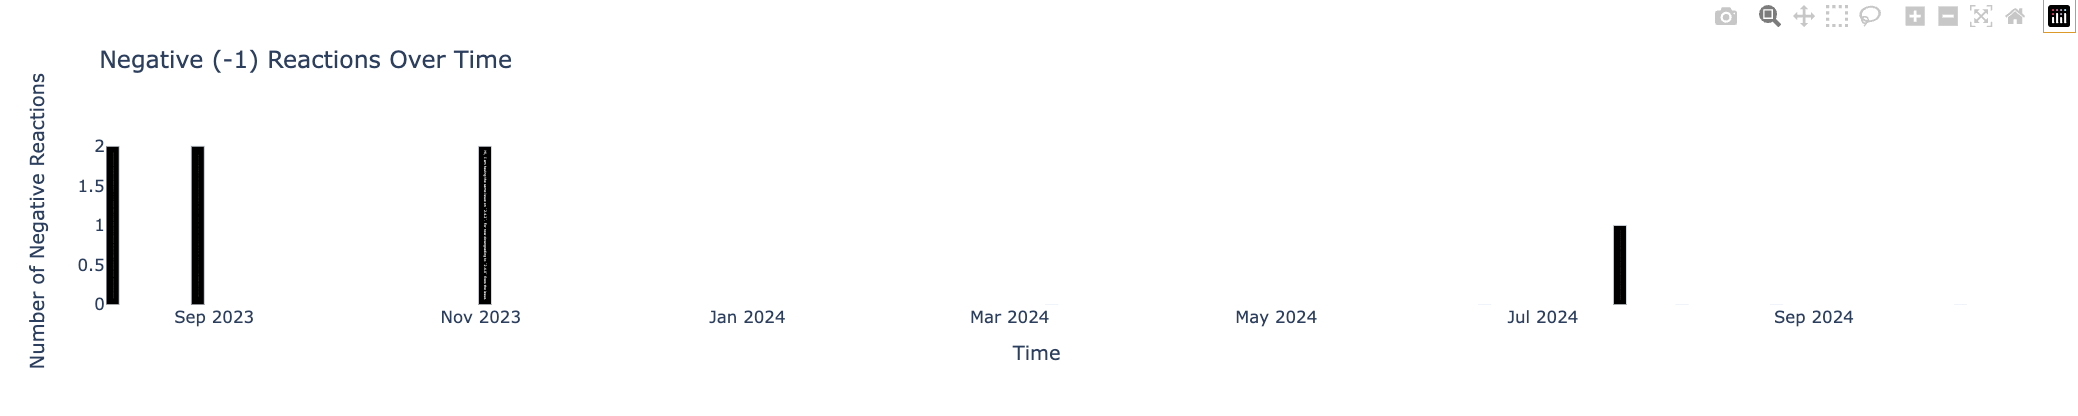